In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pywt

import lib.matnpy.matnpyio as io
import lib.matnpy.matnpy as matnpy
import lib.cnn.helpers as hlp
import lib.cnn.cnn as cnn
#from lib.cnn_1.confusion_matrix import plot_confusion_matrix

#from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

import os.path
import sys
import datetime

In [2]:
# lib for the jupyter only
import sklearn.metrics # classification_report , confusion_matrix
import matplotlib.pyplot as plt
from scipy.special import erfinv
from scipy.special import erf
import itertools

In [3]:
# function for the jupyter

def rapport(confusion_matrix):
    """
    This function returns performance measures for the classification tasks 
    """
    dico = {}
    classes = len(confusion_matrix)
    
    if classes == 2 :
        
        tp = cm[0][0]
        fp = cm[0][1]
        fn = cm[1][0]
        tn = cm[1][1]
        
        dico['accuracy'] = tp + tn /(tp +fn +fp +tn)
        dico['precision'] = tp/(tp +fp)
        dico['recall'] = tp/(tp + fn) # Sensitivity
        beta = 1
        dico['Fscore1'] = (beta**2 +1)*tp/( (beta**2 +1)*tp + beta**2*fn +fp )
        dico['Specificity'] = tn/ (fp + tn)
        dico['AUC'] = 0.5 *( tp /(tp +fn) + tn/(tn + fp) )
    else:
        fp = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
        fn = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
        tp = np.diag(confusion_matrix)
        tn = confusion_matrix.sum() - (fp + fn + tp)

        dico['average_accuracy'] = np.mean( (tp + tn)/(tp + fn + fp + tn))
        dico['error_rate'] = np.mean( (fp + fn)/(tp +fn + fp +tn) )

        #micro


        dico['precision_micro'] = np.sum(tp) / (np.sum(tp) + np.sum(fp))
        dico['recall_micro'] = np.sum(tp) / (np.sum(tp) +np.sum(fn))
        beta = 1
        dico['Fscore1_micro'] = (beta**2+1)*dico['precision_micro'] * dico['recall_micro']/( beta **2 * dico['precision_micro']+dico['recall_micro'])

        # macro

        dico['precision_macro'] = np.mean(  tp/(tp+fp) )
        dico['recall_macro'] = np.mean(  tp/(tp+fn) )
        beta = 1
        dico['Fscore1_macro'] = (beta**2+1)*dico['precision_macro'] * dico['recall_macro']/( beta **2 * dico['precision_macro']+dico['recall_macro'])
    return(dico)

#from scipy.special import erfinv
#from scipy.special import erf

def get_recall_macro(confusion_matrix,  alpha = erf(1/np.sqrt(2)) ):
    """
    This function returns the recall macro*, its error bar for a confidence interval of alpha (default at 68%),
    the accuracy per class, and the number of element of each class.
    
    recall macro is the mean of accuracy per class.
    """
    n_test = np.sum(confusion_matrix, axis = 1)
    
    classes = confusion_matrix.shape[0]
    
    
    #fp = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    fn = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    tp = np.diag(confusion_matrix)
    #tn = confusion_matrix.sum() - (fp + fn + tp)
    
    #
    recall_macro_per_class = tp/(tp+fn)
    #print(recall_macro_per_class)
    #
    recall_macro = np.mean(recall_macro_per_class)
    
    # l'écart-type théorique du recall macro, soit un interval de confiance de 0.68 = erf( 1/np.sqrt(2)) --> 1 fois l'écart-type
    error_bar = np.sqrt(2) * erfinv(alpha) *np.sqrt( np.sum(recall_macro_per_class * (1 - recall_macro_per_class)/n_test) ) /classes 
    
    return(recall_macro, error_bar, recall_macro_per_class, n_test )

#import itertools
def plot_confusion_matrix(cm, classes_names,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes_names))
    plt.xticks(tick_marks, classes_names, rotation=45)
    plt.yticks(tick_marks, classes_names)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [4]:
def wavelet_decomposition(data, depth_wav , w_name = 'db4', mode ='smooth'):
    w = pywt.Wavelet(w_name)
    a = data.copy()
    ca = []
    cd = []
    for i in range(depth_wav):
        (a, d) = pywt.dwt(a, w, mode)
        a = a[:,:,1:-2]
        d = d[:,:,1:-2]
        ca.append(a)
        cd.append(d)
    return(ca, cd)

def init_weights(shape, dist='random_normal', normalized=True):
    """Initializes network weights.
    
    Args:
        shape: A tensor. Shape of the weights.
        dist: A str. Distribution at initialization, one of 'random_normal' or 
            'truncated_normal'.
        normalized: A boolean. Whether weights should be normalized.
        
    Returns:
        A tf.variable.
    """
    # Normalized if normalized set to True
    if normalized == True:
        denom = np.prod(shape[:-1])
        std = 1e-3 / denom
    else:
        std = 1e-4
    
    # Draw from random or truncated normal
    if dist == 'random_normal':
        weights = tf.random_normal(shape, stddev=std)
    elif dist == 'truncated_normal':
        weights = tf.truncated_normal(shape, stddev=0.1)
    
    return tf.Variable(weights)

def conv2d(x, W):
    """2D convolution. """
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool(x, pool_dim):
    """Max pooling. """
    patch_height = pool_dim[0]
    patch_width = pool_dim[1]
    return tf.nn.max_pool(x, 
                          ksize=[1, patch_height, patch_width, 1], 
                          strides=[1, patch_height, patch_width, 1], 
                          padding='SAME')

def l2_loss(weights, l2_regularization_penalty, y_, y_conv, name):
    """Implements L2 loss for an arbitrary number of weights.
    
    Args:
        weights: A dict. One key/value pair per layer in the network.
        l2_regularization_penalty: An int. Scales the l2 loss arbitrarily.
        y_:
        y_conv:
        name: 
            
    Returns:
        L2 loss.        
    """
    w = {}
    for key, value in weights.items():
        w[key] = tf.nn.l2_loss(value)
    
    l2_loss = l2_regularization_penalty * sum(w.values())
    
    unregularized_loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
    return tf.add(unregularized_loss, l2_loss, name=name)

In [5]:
##########
# PARAMS #
##########
sess = '01' # '01' or '02'
sess_no = '150210'
decode_for = 'stim'

#data path
raw_path = ('/media/rudy/disk2/lucy/' + sess_no +'/session01/')
#raw_path = ('/media/rudy/disk2/lucy/'+ sess_no +'/session01/')
rinfo_path = raw_path + 'recording_info.mat'
tinfo_path = raw_path + 'trial_info.mat'

#target_area = ['V1']
target_cortex = 'Visual'
target_area = io.get_area_cortex(rinfo_path, target_cortex, unique = True)

align_on ,from_time, to_time ='sample', -6, 506


mode = 'smooth'
elec_type = 'grid'  # any one of single|grid|average

#only_correct_trials = False  
if decode_for == 'stim':
    only_correct_trials = True
else:
    only_correct_trials = False

In [6]:
#CNN PARAMS

n_layers = 6
depth_wav = 7
in_1, out_1 = 1, 6
in_2, out_2 = 7, 21
in_3, out_3 = 22, 41
in_4, out_4 = 42, 69
in_5, out_5 = 70,97 
in_6, out_6 = 98, 122
fc_units = 100


pool_dim = [1, 2] #size of max_pool
patch_dim = [1, 7] # taille de la fenêtre de convolution
patch_dim5 = [1, 3]
patch_dim6 = [1, 2]
nonlin = 'elu' # leaky_relu'

n_iterations = 2000

learning_rate = 1e-4
size_of_batches = 15

keep_prob_train = .2
l2_regularization_penalty = 0#0.001
amplify_input = True # q**..
q = 4

dist = 'random_normal'
normalized_weights = True

bn = False # Indicating whether batch-norm shoud be applied
batch_norm = 'renorm'  # 'after'
DECAY = .999

In [7]:
########
# DATA #
########

# train/test size, random split 
# train_size = .8
# test_size = .2
seed = 8392 # np.random.randint(1,10000)
n_splits = 5


# Auto-define number of classes
classes = 2 if decode_for == 'resp' else 5

# Load data and targets
data = matnpy.get_subset_by_areas(sess_no, raw_path, 
                         align_on, from_time, to_time, 
                         target_area,
                         only_correct_trials = only_correct_trials, renorm = False, elec_type = elec_type )
n_chans = data.shape[1]

targets = io.get_targets(decode_for, raw_path,n_chans, elec_type=elec_type,
                        only_correct_trials=only_correct_trials,
                        onehot=True)

# indices = np.arange(len(data))
# train, test, train_labels, test_labels, idx_train, idx_test = (
#         train_test_split(
#             data, 
#             targets, 
#             indices,
#             test_size=test_size, 
#             random_state=seed)
#         )

15021001.0001.mat
15021001.0002.mat
15021001.0003.mat
15021001.0004.mat
15021001.0005.mat
15021001.0006.mat
15021001.0007.mat
15021001.0008.mat
15021001.0009.mat
15021001.0010.mat
15021001.0011.mat
15021001.0012.mat
15021001.0013.mat
15021001.0014.mat
15021001.0015.mat
15021001.0016.mat
15021001.0017.mat
15021001.0018.mat
15021001.0019.mat
15021001.0020.mat
15021001.0021.mat
15021001.0022.mat
15021001.0023.mat
15021001.0024.mat
15021001.0025.mat
15021001.0026.mat
15021001.0027.mat
15021001.0028.mat
15021001.0029.mat
15021001.0030.mat
15021001.0031.mat
15021001.0032.mat
15021001.0033.mat
15021001.0034.mat
15021001.0035.mat
15021001.0036.mat
15021001.0037.mat
15021001.0038.mat
15021001.0039.mat
15021001.0040.mat
15021001.0041.mat
15021001.0042.mat
15021001.0043.mat
15021001.0044.mat
15021001.0045.mat
15021001.0046.mat
15021001.0047.mat
15021001.0048.mat
15021001.0049.mat
15021001.0050.mat
15021001.0051.mat
15021001.0052.mat
15021001.0053.mat
15021001.0054.mat
15021001.0055.mat
15021001.0

15021001.0452.mat
15021001.0453.mat
15021001.0454.mat
15021001.0455.mat
15021001.0456.mat
15021001.0457.mat
15021001.0458.mat
15021001.0459.mat
15021001.0460.mat
15021001.0461.mat
15021001.0462.mat
15021001.0463.mat
15021001.0464.mat
15021001.0465.mat
15021001.0466.mat
15021001.0467.mat
15021001.0468.mat
15021001.0469.mat
15021001.0470.mat
15021001.0471.mat
15021001.0472.mat
15021001.0473.mat
15021001.0474.mat
15021001.0475.mat
15021001.0476.mat
15021001.0477.mat
15021001.0478.mat
15021001.0479.mat
15021001.0480.mat
15021001.0481.mat
15021001.0482.mat
15021001.0483.mat
15021001.0484.mat
15021001.0485.mat
15021001.0486.mat
15021001.0487.mat
15021001.0488.mat
15021001.0489.mat
15021001.0490.mat
15021001.0491.mat
15021001.0492.mat
15021001.0493.mat
15021001.0494.mat
15021001.0495.mat
15021001.0496.mat
15021001.0497.mat
15021001.0498.mat
15021001.0499.mat
15021001.0500.mat
15021001.0501.mat
15021001.0502.mat
15021001.0503.mat
15021001.0504.mat
15021001.0505.mat
15021001.0506.mat
15021001.0

15021001.0910.mat
15021001.0911.mat
15021001.0912.mat
15021001.0913.mat
15021001.0914.mat
15021001.0915.mat
15021001.0916.mat
15021001.0917.mat
15021001.0918.mat
15021001.0919.mat
15021001.0920.mat
15021001.0921.mat
15021001.0922.mat
15021001.0923.mat
15021001.0924.mat
15021001.0925.mat
15021001.0926.mat
15021001.0927.mat
15021001.0928.mat
15021001.0929.mat
15021001.0930.mat
15021001.0931.mat
15021001.0932.mat
15021001.0933.mat
15021001.0934.mat
15021001.0935.mat
15021001.0936.mat
15021001.0937.mat
15021001.0938.mat
15021001.0939.mat
15021001.0940.mat
15021001.0941.mat
15021001.0942.mat
15021001.0943.mat
15021001.0944.mat
15021001.0945.mat
15021001.0946.mat
15021001.0947.mat
15021001.0948.mat
15021001.0949.mat
15021001.0950.mat
15021001.0951.mat
15021001.0952.mat
15021001.0953.mat
15021001.0954.mat
15021001.0955.mat
15021001.0956.mat
15021001.0957.mat
15021001.0958.mat
15021001.0959.mat
15021001.0960.mat
15021001.0961.mat
15021001.0962.mat
15021001.0963.mat
15021001.0964.mat
15021001.0

In [8]:
# wavelet decomposition        
depth_wav = 7
ca, cd = wavelet_decomposition(data, depth_wav=depth_wav) # ca size = depth_wav * n_trials * n_chans * 2*8-i

In [9]:
## RESHAPE DATA

depth_wav = 7
ca_train = 7 *[0]
cd_train = 7 *[0]
for i in range(depth_wav):
    ca_train[i] = np.reshape(np.array(ca[i]),(len(ca[i]), len(ca[i][0]), len(ca[i][0][0]), 1))
    cd_train[i] = np.reshape(np.array(cd[i]),(len(cd[i]), len(cd[i][0]), len(cd[i][0][0]), 1))


ca = ca_train
cd = cd_train

In [10]:
## AMPLIFY INPUT    
if amplify_input == True :
    for i in range(len(ca)):
        cd[i] = 10000 * (q**(len(ca)-i-1)) *cd[i]**2

## slit train/ test
#ca_train = [ca[i][idx_train, :, : , :] for i in range(len(ca))]
#cd_train = [cd[i][idx_train, :, : , :] for i in range(len(cd))]

#ca_test = [ca[i][idx_test, :, : , :] for i in range(len(ca))]
#cd_test = [cd[i][idx_test, :, : , :] for i in range(len(cd))]

In [11]:
############## 
# CREATE CNN #
##############

if elec_type == 'single':
    n_chans = 1
x_1 = tf.placeholder(tf.float32, shape=[None, n_chans , 128, 1])
x_2 = tf.placeholder(tf.float32, shape=[None, n_chans , 64, 1])
x_3 = tf.placeholder(tf.float32, shape=[None, n_chans , 32, 1])
x_4 = tf.placeholder(tf.float32, shape=[None, n_chans , 16, 1])
x_5 = tf.placeholder(tf.float32, shape=[None, n_chans , 8, 1])
x_6 = tf.placeholder(tf.float32, shape=[None, n_chans , 4, 1])



keep_prob = tf.placeholder(tf.float32)
y_ = tf.placeholder(tf.float32, shape=[None, classes])

training = tf.placeholder_with_default(True, shape=())

weights = {}

# first_layer
weights_1 = init_weights([patch_dim[0], patch_dim[1], in_1, out_1], 
                    dist=dist,
                    normalized=normalized_weights)
conv_1 = conv2d(x_1, weights_1)
conv_1_elu = tf.nn.elu(conv_1)
if bn == True:
    conv_1_bn_elu = tf.contrib.layers.batch_norm(
        conv_1_elu,
        data_format='NHWC',
        center=True,
        scale=True,
        is_training=training,
        decay=DECAY,
        renorm=True)
    maxpool_1_bn_elu = max_pool(conv_1_bn_elu, pool_dim)
else:
    maxpool_1_bn_elu = max_pool(conv_1_elu, pool_dim)

weights[0] = weights_1    

# second layer
concat_2 = tf.concat((maxpool_1_bn_elu, x_2), axis = 3)
weights_2 = init_weights([patch_dim[0], patch_dim[1], in_2, out_2], 
                    dist=dist,
                    normalized=normalized_weights)
conv_2 = conv2d(concat_2, weights_2)
conv_2_elu = tf.nn.elu(conv_2)
if bn == True:
    conv_2_bn_elu = tf.contrib.layers.batch_norm(
        conv_2_elu,
        data_format='NHWC',
        center=True,
        scale=True,
        is_training=training,
        decay=DECAY,
        renorm=True)
    maxpool_2_bn_elu = max_pool(conv_2_bn_elu, pool_dim)
else:
    maxpool_2_bn_elu = max_pool(conv_2_elu, pool_dim)

weights[1] = weights_2  

# 3 layer
concat_3 = tf.concat((maxpool_2_bn_elu, x_3), axis = 3)
weights_3 = init_weights([patch_dim[0], patch_dim[1], in_3, out_3], 
                    dist=dist,
                    normalized=normalized_weights)
conv_3 = conv2d(concat_3, weights_3)
conv_3_elu = tf.nn.elu(conv_3)
if bn == True:
    conv_3_bn_elu = tf.contrib.layers.batch_norm(
        conv_3_elu,
        data_format='NHWC',
        center=True,
        scale=True,
        is_training=training,
        decay=DECAY,
        renorm=True)
    maxpool_3_bn_elu = max_pool(conv_3_bn_elu, pool_dim)
else:
    maxpool_3_bn_elu = max_pool(conv_3_elu, pool_dim)

weights[2] = weights_3  

# 4 layer
concat_4 = tf.concat((maxpool_3_bn_elu, x_4), axis = 3)
weights_4 = init_weights([patch_dim[0], patch_dim[1], in_4, out_4], 
                    dist=dist,
                    normalized=normalized_weights)
conv_4 = conv2d(concat_4, weights_4)
conv_4_elu = tf.nn.elu(conv_4)
if bn == True:
    conv_4_bn_elu = tf.contrib.layers.batch_norm(
        conv_4_elu,
        data_format='NHWC',
        center=True,
        scale=True,
        is_training=training,
        decay=DECAY,
        renorm=True)
    maxpool_4_bn_elu = max_pool(conv_4_bn_elu, pool_dim)
else:
    maxpool_4_bn_elu = max_pool(conv_4_elu, pool_dim)

weights[3] = weights_4  

# 5 layer
concat_5 = tf.concat((maxpool_4_bn_elu, x_5), axis = 3)
weights_5 = init_weights([patch_dim5[0], patch_dim5[1], in_5, out_5], 
                    dist=dist,
                    normalized=normalized_weights)
conv_5 = conv2d(concat_5, weights_5)
conv_5_elu = tf.nn.elu(conv_5)
if bn == True:
    conv_5_bn_elu = tf.contrib.layers.batch_norm(
        conv_5_elu,
        data_format='NHWC',
        center=True,
        scale=True,
        is_training=training,
        decay=DECAY,
        renorm=True)
    maxpool_5_bn_elu = max_pool(conv_5_bn_elu, pool_dim)
else:
    maxpool_5_bn_elu = max_pool(conv_5_elu, pool_dim)

weights[4] = weights_5 

# _6 layer
concat_6 = tf.concat((maxpool_5_bn_elu, x_6), axis = 3)
weights_6 = init_weights([patch_dim6[0], patch_dim6[1], in_6, out_6], 
                    dist=dist,
                    normalized=normalized_weights)
conv_6 = conv2d(concat_6, weights_6)
conv_6_elu = tf.nn.elu(conv_6)
if bn == True:
    conv_6_bn_elu = tf.contrib.layers.batch_norm(
        conv_6_elu,
        data_format='NHWC',
        center=True,
        scale=True,
        is_training=training,
        decay=DECAY,
        renorm=True)
    maxpool_6_bn_elu = max_pool(conv_6_bn_elu, pool_dim)
else:
    maxpool_6_bn_elu = max_pool(conv_6_elu, pool_dim)

weights[5] = weights_6 
# FC

fc1, weights[n_layers] = cnn.fully_connected(maxpool_6_bn_elu,
                                        bn=True, 
                                        units=fc_units,
                                        training=training,
                                        nonlin=nonlin,
                                        weights_dist=dist,
                                        normalized_weights=normalized_weights)

# Dropout (BN)
fc1_drop = tf.nn.dropout(fc1, keep_prob)

# Readout
weights[n_layers+1] = init_weights([fc_units, classes])
y_conv = tf.matmul(fc1_drop, weights[n_layers+1])
softmax_probs = tf.contrib.layers.softmax(y_conv)
weights_shape = [tf.shape(el) for el in weights.values()]

# LOSS
loss = l2_loss(weights, 
            l2_regularization_penalty, 
            y_, 
            y_conv, 
            'loss')


# Optimizer
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
prediction = tf.argmax(y_conv, 1)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [12]:
#ind_test = hlp.subset_test(test_labels, classes)

kf = StratifiedKFold(n_splits=n_splits,shuffle=True, random_state=seed)


#n_test_list = []
confusion_matrix_list = []
y_true_list = []
y_pred_list = []
mean_per_class_accuracy_train_per_fold = []

cross_validation_i = 0
#for train_index, test_index in kf.split(data):  KFOLD
for train_index, test_index in kf.split(data, np.argmax(targets[:,:], axis=1)):
    cross_validation_i += 1
    #print('####################################')
    #print('         NUMERO   ', cross_validation_i, '/5')
    #print('####################################')

    ca_train = [ca[i][train_index, :, : , :] for i in range(len(ca))]
    cd_train = [cd[i][train_index, :, : , :] for i in range(len(cd))]
    train_labels = targets[train_index]

    ca_test = [ca[i][test_index, :, : , :] for i in range(len(ca))]
    cd_test = [cd[i][test_index, :, : , :] for i in range(len(cd))]
    test_labels = targets[test_index]




    #ind_test = hlp.subset_test(test_labels, classes)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        # Number of batches to train on
        for i in range(n_iterations):
            ind_train = hlp.subset_train(train_labels, classes, size_of_batches)

            ## Every n iterations, print training accuracy
            if i % 50 == 0:
                train_accuracy = accuracy.eval(feed_dict={
                    x_1: cd_train[1][ind_train,:,:],
                    x_2: cd_train[2][ind_train,:,:],
                    x_3: cd_train[3][ind_train,:,:],
                    x_4: cd_train[4][ind_train,:,:],
                    x_5: cd_train[5][ind_train,:,:],
                    x_6: cd_train[6][ind_train,:,:],
                    y_: train_labels[ind_train,:],
                    keep_prob: 1.0
                    })
                print('step %d, training accuracy: %g' % (
                        i, train_accuracy))

            # Training

            train_step.run(feed_dict={
                    x_1: cd_train[1][ind_train,:,:],
                    x_2: cd_train[2][ind_train,:,:],
                    x_3: cd_train[3][ind_train,:,:],
                    x_4: cd_train[4][ind_train,:,:],
                    x_5: cd_train[5][ind_train,:,:],
                    x_6: cd_train[6][ind_train,:,:],
                    y_: train_labels[ind_train,:],
                    keep_prob: keep_prob_train
                    })

        ### TRAINING ACCURACY last step

        y_pred = prediction.eval(feed_dict={
                        x_1: cd_train[1][:,:,:],
                        x_2: cd_train[2][:,:,:],
                        x_3: cd_train[3][:,:,:],
                        x_4: cd_train[4][:,:,:],
                        x_5: cd_train[5][:,:,:],
                        x_6: cd_train[6][:,:,:],
                        y_: train_labels[:,:],
                        keep_prob: 1.0
                        })
        # get mean of accuracy per class
        acc_train, error_bar = cnn.mean_accuracy_per_class(np.argmax(train_labels[:,:],1), y_pred)
        # append to list in order to save it
        mean_per_class_accuracy_train_per_fold.append(acc_train)

        ### TEST ACCURACY ###

        # Print test accuracy on balanced test base
        y_pred =  prediction.eval(feed_dict={
            x_1: cd_test[1][:,:,:],
            x_2: cd_test[2][:,:,:],
            x_3: cd_test[3][:,:,:],
            x_4: cd_test[4][:,:,:],
            x_5: cd_test[5][:,:,:],
            x_6: cd_test[6][:,:,:],
            y_: test_labels[:,:],
            keep_prob: 1.0
            })
        
        acc, error_bar = cnn.mean_accuracy_per_class(np.argmax(test_labels[:,:],1), y_pred)
        print('mean acc : %g +- %g ' % (acc, error_bar))         
        

        table_confusion = confusion_matrix(
            np.argmax(test_labels[:,:],1),
            y_pred)

        # append
        y_pred_list.append( list(y_pred) )
        y_true_list.append( list( np.argmax(test_labels[:,:],1)) )
        confusion_matrix_list.append(list(table_confusion)) 
        



cnf = np.array(confusion_matrix_list)
mean_accuracy_per_class_per_fold = []
error_bar_per_fold = []
for k in range(cnf.shape[0]):
    # Calculate average of accuracy of class on the k fold 
    n_test = np.sum(cnf[k], axis =1)
    tp = np.diag(cnf[k])
    fn = cnf[k].sum(axis=1) - np.diag(cnf[k])
    
    accuracy_per_class = tp/(tp+fn)
    
    mean_accuracy_per_class = np.mean( accuracy_per_class )
    
    error_bar = np.sqrt( np.sum( accuracy_per_class * (1 - accuracy_per_class)/n_test) ) /classes
    
    mean_accuracy_per_class_per_fold.append(mean_accuracy_per_class)
    error_bar_per_fold.append(error_bar)
    
# result = mean on folds 
mean_accuracy_per_class = np.mean(mean_accuracy_per_class_per_fold)
error_bar = np.sqrt(np.sum( np.array(error_bar_per_fold) **2 ))/len(error_bar_per_fold)

    

#acc_mean =  np.mean(acc_balanced_list)

channels_in = [in_1, in_2, in_3, in_4, in_5, in_6]
channels_out = [out_1, out_2, out_3, out_4, out_5, out_6]
interval = align_on



            
            

step 0, training accuracy: 0.333333
step 50, training accuracy: 0.2
step 100, training accuracy: 0.466667
step 150, training accuracy: 0.266667
step 200, training accuracy: 0.333333
step 250, training accuracy: 0.333333
step 300, training accuracy: 0.266667
step 350, training accuracy: 0.6
step 400, training accuracy: 0.4
step 450, training accuracy: 0.733333
step 500, training accuracy: 0.933333
step 550, training accuracy: 0.866667
step 600, training accuracy: 0.8
step 650, training accuracy: 0.6
step 700, training accuracy: 0.866667
step 750, training accuracy: 0.933333
step 800, training accuracy: 0.933333
step 850, training accuracy: 1
step 900, training accuracy: 1
step 950, training accuracy: 0.8
step 1000, training accuracy: 1
step 1050, training accuracy: 0.933333
step 1100, training accuracy: 0.933333
step 1150, training accuracy: 0.933333
step 1200, training accuracy: 0.8
step 1250, training accuracy: 1
step 1300, training accuracy: 1
step 1350, training accuracy: 0.866667
s

In [13]:
#





k-Fold num° 1
confusion matrix :
[[16  0  5  0  0]
 [ 0 15  0  0  4]
 [ 2  0 12  1  4]
 [ 0  0  0 24  0]
 [ 1  7  3  0 14]]
Normalized confusion matrix


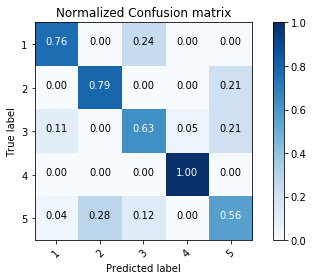


recall_macro (moyenne des taux de réussite de chaque classe):
average per-class effectiveness of a classifier to identify class labels
74.86  +-  3.97  %

Report classifier :
              precision    recall  f1-score   support

           0       0.84      0.76      0.80        21
           1       0.68      0.79      0.73        19
           2       0.60      0.63      0.62        19
           3       0.96      1.00      0.98        24
           4       0.64      0.56      0.60        25

   micro avg       0.75      0.75      0.75       108
   macro avg       0.74      0.75      0.74       108
weighted avg       0.75      0.75      0.75       108

average_accuracy  :  0.9
error_rate  :  0.1
precision_micro  :  0.75
recall_micro  :  0.75
Fscore1_micro  :  0.75
precision_macro  :  0.7440574162679425
recall_macro  :  0.7485914786967418
Fscore1_macro  :  0.7463175611602547


k-Fold num° 2
confusion matrix :
[[20  0  1  0  0]
 [ 0 16  0  0  2]
 [ 3  0 12  1  3]
 [ 0  0  1 23  0]
 [

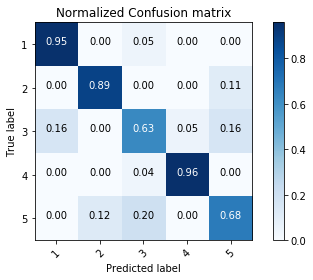


recall_macro (moyenne des taux de réussite de chaque classe):
average per-class effectiveness of a classifier to identify class labels
82.22  +-  3.48  %

Report classifier :
              precision    recall  f1-score   support

           0       0.87      0.95      0.91        21
           1       0.84      0.89      0.86        18
           2       0.63      0.63      0.63        19
           3       0.96      0.96      0.96        24
           4       0.77      0.68      0.72        25

   micro avg       0.82      0.82      0.82       107
   macro avg       0.81      0.82      0.82       107
weighted avg       0.82      0.82      0.82       107

average_accuracy  :  0.9289719626168222
error_rate  :  0.07102803738317756
precision_micro  :  0.822429906542056
recall_micro  :  0.822429906542056
Fscore1_micro  :  0.822429906542056
precision_macro  :  0.8148620067956452
recall_macro  :  0.8222364243943192
Fscore1_macro  :  0.8185326063203401


k-Fold num° 3
confusion matrix :
[[17

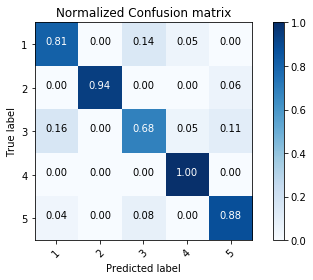


recall_macro (moyenne des taux de réussite de chaque classe):
average per-class effectiveness of a classifier to identify class labels
86.36  +-  3.22  %

Report classifier :
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        21
           1       1.00      0.94      0.97        18
           2       0.72      0.68      0.70        19
           3       0.92      1.00      0.96        23
           4       0.88      0.88      0.88        25

   micro avg       0.87      0.87      0.87       106
   macro avg       0.87      0.86      0.86       106
weighted avg       0.87      0.87      0.87       106

average_accuracy  :  0.9471698113207548
error_rate  :  0.052830188679245285
precision_micro  :  0.8679245283018868
recall_micro  :  0.8679245283018868
Fscore1_micro  :  0.8679245283018869
precision_macro  :  0.8663492063492063
recall_macro  :  0.8636357560568086
Fscore1_macro  :  0.8649903532040222


k-Fold num° 4
confusion matrix :


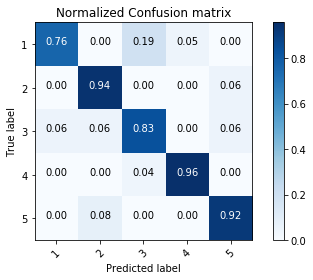


recall_macro (moyenne des taux de réussite de chaque classe):
average per-class effectiveness of a classifier to identify class labels
88.32  +-  3.1  %

Report classifier :
              precision    recall  f1-score   support

           0       0.94      0.76      0.84        21
           1       0.85      0.94      0.89        18
           2       0.75      0.83      0.79        18
           3       0.96      0.96      0.96        23
           4       0.92      0.92      0.92        25

   micro avg       0.89      0.89      0.89       105
   macro avg       0.88      0.88      0.88       105
weighted avg       0.89      0.89      0.89       105

average_accuracy  :  0.9542857142857143
error_rate  :  0.045714285714285714
precision_micro  :  0.8857142857142857
recall_micro  :  0.8857142857142857
Fscore1_micro  :  0.8857142857142857
precision_macro  :  0.8835396419437339
recall_macro  :  0.8832408557625948
Fscore1_macro  :  0.8833902235887973


k-Fold num° 5
confusion matrix :
[

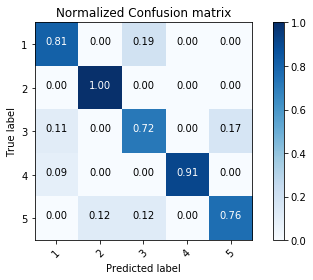


recall_macro (moyenne des taux de réussite de chaque classe):
average per-class effectiveness of a classifier to identify class labels
84.1  +-  3.42  %

Report classifier :
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        21
           1       0.86      1.00      0.92        18
           2       0.65      0.72      0.68        18
           3       1.00      0.91      0.95        23
           4       0.86      0.76      0.81        25

   micro avg       0.84      0.84      0.84       105
   macro avg       0.84      0.84      0.84       105
weighted avg       0.84      0.84      0.84       105

average_accuracy  :  0.9352380952380953
error_rate  :  0.06476190476190476
precision_micro  :  0.8380952380952381
recall_micro  :  0.8380952380952381
Fscore1_micro  :  0.8380952380952381
precision_macro  :  0.836060606060606
recall_macro  :  0.8409579020013803
Fscore1_macro  :  0.8385021033921016


In [14]:
for k in range(n_splits):
        
    print('\n')
    
    print('k-Fold num°', k+1)
    
    y_true = y_true_list[k]
    y_pred = y_pred_list[k] 
       
    
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)

    recall_macro, error_bar, recall_macro_per_class, n_test = get_recall_macro(confusion_matrix)

    classif_report_per_class = sklearn.metrics.classification_report(y_true, y_pred)
    classif_report = rapport(confusion_matrix) 


    print('confusion matrix :')
    print(confusion_matrix)
    plt.figure()
    classes_names = np.arange(1,classes+1,1)
    plot_confusion_matrix(confusion_matrix, classes_names, normalize=True, title='Normalized Confusion matrix')
    plt.show()

    print('\nrecall_macro (moyenne des taux de réussite de chaque classe):')
    print('average per-class effectiveness of a classifier to identify class labels')
    print( round(100* recall_macro, 2), ' +- ', round(100*error_bar, 2), ' %')

    print('\nReport classifier :')
    print(classif_report_per_class)

    for key in classif_report:
        print(key,' : ',classif_report[key] )
    

In [15]:
### mean on k_fold result
recall_macro_per_kfold = np.zeros( (n_splits) )
error_bar_per_kfold = np.zeros( (n_splits) )
for k in range(n_splits):
    
    y_true = y_true_list[k]
    y_pred = y_pred_list[k] 
    
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
    
    recall_macro, error_bar, recall_macro_per_class, n_test = get_recall_macro(confusion_matrix)
    
    recall_macro_per_kfold[k] = recall_macro # key start at 1
    error_bar_per_kfold[k] = error_bar
    
print('recall macro sur chaque k_fold')
print(recall_macro_per_kfold )
    
print('\nMoyenne')
recall_macro_mean = np.mean(recall_macro_per_kfold)

print( round( 100 *recall_macro_mean, 1) )

print("\nBarre d'erreur")
error_bar = np.sqrt( np.sum( error_bar_per_kfold**2) )/classes


print( round(100 *error_bar, 2) )

recall macro sur chaque k_fold
[0.74859148 0.82223642 0.86363576 0.88324086 0.8409579 ]

Moyenne
83.2

Barre d'erreur
1.54


In [16]:
np.std(recall_macro_per_kfold, ddof=1 )*100/np.sqrt(5)

2.319336260413274

In [17]:
confusion_matrix_all = np.sum(cnf, axis = 0)
recall_macro, error_bar, recall_macro_per_class, n_test = get_recall_macro(confusion_matrix_all)

print('\nMoyenne')
print(round(100*recall_macro,1))
print('\nError bar')
print(round(100 *error_bar, 2))


Moyenne
83.1

Error bar
1.59
